---
# **Introduction to Deep Learning Chapter 2**

#Image Recognition with DL Models

---

## **Install libraries and tools**
**Execute this code beforehand**

In [30]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# A small package to create visualizations of PyTorch execution graphs and traces.
# https://github.com/szagoruyko/pytorchviz
!pip install torchviz | tail -n 1
from torchviz import make_dot  # visualize the PyTorch models

# Torchinfo provides information complementary to what is provided by print(your_model) in PyTorch, 
# similar to Tensorflow's model.summary() API to view the visualization of the model,
# which is helpful while debugging your network.
# https://github.com/TylerYep/torchinfo
!pip install torchinfo | tail -n 1
from torchinfo import summary  # display the summary of PyTorch models

# Set random seed (reproduce the same results every time)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True


## **Device allocation**
**Execute this code beforehand**

In [42]:
# Device allocation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## **Check GPU status**

In [43]:
!nvidia-smi

Wed Jan 25 05:29:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |   7964MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **define utility functions**
**Execute this code beforehand.**

This section defines some utility functions. Check the implementation of these functions as necessary.

In [44]:
# A function for learning process
def fit(model, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # import tqdm library (progress bar)
    from tqdm.notebook import tqdm

    start_epoch = len(history)
    end_epoch = start_epoch + num_epochs

    # training loop
    for i in range(start_epoch, end_epoch):
        train_acc, train_loss = 0, 0
        val_acc, val_loss = 0, 0
        n_train, n_test = 0, 0

        # minibatch loop　（Learing phase)
        model.train()
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device) # send inputs to GPU
            labels = labels.to(device) # send inputs to GPU
    
            n_train += len(labels)              # count the number of training data
            optimizer.zero_grad()               # gradient initialization
            outputs = model(inputs)             # [Step1] prediction(forward calculation)
            loss = criterion(outputs, labels)   # [Step2] loss calculation
            loss.backward()                     # [Step3] backward propabation
            optimizer.step()                    # [Step4] parameter update

            prediction = torch.max(outputs, 1)[1]            # predicted label
            train_loss += loss.item()                        # loss
            train_acc += (prediction == labels).sum().item() # accuracy

        # Validation phase
        model.eval()
        for inputs_test, labels_test in test_loader:
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            n_test += len(labels_test)          # count the number of test data
            outputs_test = model(inputs_test)                   # prediction(forward calculation)
            loss_test = criterion(outputs_test, labels_test)    # loss calculation
            prediction_test = torch.max(outputs_test, 1)[1]     # predected label

            val_loss +=  loss_test.item()   #loss
            val_acc +=  (prediction_test == labels_test).sum().item()  # accuracy

        # record loss and accuracy
        train_acc = train_acc / n_train
        val_acc = val_acc / n_test
        train_loss = train_loss / n_train
        val_loss = val_loss / n_test
        print (f'Epoch [{i+1}/{end_epoch}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([i+1 , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

    return history


def show_loss_and_accuracy_graph(history):
    # Check loss and accuracy
    print(f'Before learning: Loss: {history[0,3]:.5f} Accuracy: {history[0,4]:.5f}')
    print(f'After learning : Loss: {history[-1,3]:.5f} Accuracy: {history[-1,4]:.5f}')

    # Display learning curve (Loss)
    plt.rcParams['figure.figsize'] = (9,8)
    plt.plot(history[:,0], history[:,1], 'b', label='training')
    plt.plot(history[:,0], history[:,3], 'k', label='test')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('learning curve(loss)')
    plt.legend()
    plt.show()

    # Display learning curve (Accuracy)
    plt.rcParams['figure.figsize'] = (9,8)
    plt.plot(history[:,0], history[:,2], 'b', label='training')
    plt.plot(history[:,0], history[:,4], 'k', label='test')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('learning curve(accuracy)')
    plt.legend()
    plt.show()


def show_confusion_matrix(model, dataloader, class_names, device):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    y_pred = []
    y_true = []

    # iterate over test data
    for inputs_test, labels_test in dataloader:
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)
            
            outputs_test = model(inputs_test)     # prediction(forward calculation)
            prediction_test = torch.max(outputs_test, 1)[1].data.cpu().numpy()  # predected label
            y_pred.extend(prediction_test) # Save Prediction
            
            labels = labels_test.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
    cmp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10,10))
    cmp.plot(cmap=plt.cm.Blues, ax=ax)


def show_misrecognizd_images(model, dataloader, img_shape, class_names, device):
    count = 0

    # Display 50 images with "correct label : prediction"
    plt.figure(figsize=(15, 20))
    for images, labels in dataloader:
        # obtain predicted labels
        inputs = images.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predicted = torch.max(outputs, 1)[1]

        for i in np.arange(images.shape[0]):
            image_np = images[i].numpy().copy() # Tensor to NumPy
            label = labels[i]
            pred = predicted[i]
            if (pred != label):
                ax = plt.subplot(10, 10, count+1)
                img = image_np.reshape(img_shape)
                if(len(img_shape) == 3):
                    img = np.transpose(img, (1, 2, 0)) # Change axis order (channel, row, column) -> (row, column, channel)
                img = (img + 1)/2   # Revert the range of values ​​from [-1,1] to [0,1]

                # show result
                plt.imshow(img, cmap='gray')
                ax.set_title(f'{class_names[label]}:{class_names[pred]}')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                count += 1
                if count == 100:
                    break
        else:
            continue
        break

    plt.show()


def show_image(img, imgtype='np', cmap='gray', figsize=(10,6), vmin=None, vmax=None):
    if(imgtype == "tensor"):
        img = img.numpy()

    if(imgtype == "np" or imgtype == "tensor"):
        if(len(img.shape) == 3):
            img = np.transpose(img, (1, 2, 0)) # Change axis order (channel, row, column) -> (row, column, channel)        

    plt.figure(figsize=figsize)
    plt.imshow(img, cmap, vmin, vmax)
    plt.show()

def show_kernels(model, kernel_key, figsize=(20,1), subplotsize=16, img_max_num=48):
    kernels = np.array(model.state_dict()[kernel_key].cpu())
    kernel_num = kernels.shape[0]
    channel_num = kernels.shape[1]

    img_index = 0
    for k in range(kernel_num):
        for c in range(channel_num):
            if(img_index % subplotsize == 0):
                plt.show()
                plt.figure(figsize=figsize)

            plt.subplot(1, subplotsize, img_index % subplotsize + 1)
            plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
            plt.title(f"k,c:{k},{c}")
            plt.imshow(kernels[k][c], cmap="gray")
            img_index += 1
            if(img_index >= img_max_num):
                break
        else:
            continue
        break

def feature_to_img(feature, nrow=4, img_width=1000):
    feature = feature.unsqueeze(1)  # (N, H, W) -> (N, C, H, W)
    img = torchvision.utils.make_grid(feature.cpu(), nrow=nrow, normalize=True, pad_value=1)     # make images and arrange in a grid
    img = transforms.functional.to_pil_image(img)    # tensor to  PIL Image
    img_height = int(img_width * img.height / img.width)  # resize
    img = img.resize((img_width, img_height))
    return img

def show_features(features, nrow=10):
    for name, x in features.items():
        img = feature_to_img(feature=x, nrow=nrow)
        print(name, x.shape)
        display(img)

def save_checkpoint(model, optimizer, history, filepath):
    checkpoint = {
        'model_state_dict': model.to('cpu').state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
        }
    print("saving checkpoint '{}'".format(filepath))
    torch.save(checkpoint, filepath)


# Note: Input model & optimizer should be pre-defined.  This function only updates their states.
import os
def load_checkpoint(model, optimizer, filepath):

    if os.path.isfile(filepath):
        print("loading checkpoint '{}'".format(filepath))
    else:
        print("File not found: '{}'".format(filepath))
        return
    
    start_epoch = 0        
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    history = checkpoint['history']

    print(checkpoint)

    return model, optimizer, history

---
# **Classification of CIFER-10 using CNN**
---

## 🤔**Exercise 2.1** Data Preparation of CIFER-10 (Dataset, Transforms and DataLoader)

Implement Dataset, Transforms and DataLoader to use CIFER-10 dataset.

In [5]:
import torchvision.datasets as datasets         # for using CIFER-10 dataset
import torchvision.transforms as transforms     # Transforms
from torch.utils.data import DataLoader         # DataLoader

### Implement Transforms -----------------------------------

transform_for_MLP = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

###---------------------------------------------------------

### Implement Dataset (both for training and testing) ------
data_root = './data'

train_set_CIFAR10 = datasets.CIFAR10(
    root = data_root,
    train = True,
    download = True,
    transform = transform_for_MLP)

test_set_CIFAR10 = datasets.CIFAR10(
    root = data_root,
    train = False,
    download = True,
    transform = transform_for_MLP)

###---------------------------------------------------------

class_names_CIFAR10 = ('airplane',
                   'automobile',
                   'bird',
                   'cat',
                   'deer',
                   'dog',
                   'frog',
                   'horse',
                   'ship',
                   'truck')

### Implement DataLoader  (both for training and testing) ----

batch_size = 100

train_loader_CIFAR10 = DataLoader( train_set_CIFAR10, batch_size = batch_size, shuffle = True)

test_loader_CIFAR10 = DataLoader( test_set_CIFAR10, batch_size = batch_size, shuffle = False)

###-----------------------------------------------------------

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 🤔**Exercise 2.2** Model definition (Model_CNN4: CNN with 2 convolution layers)

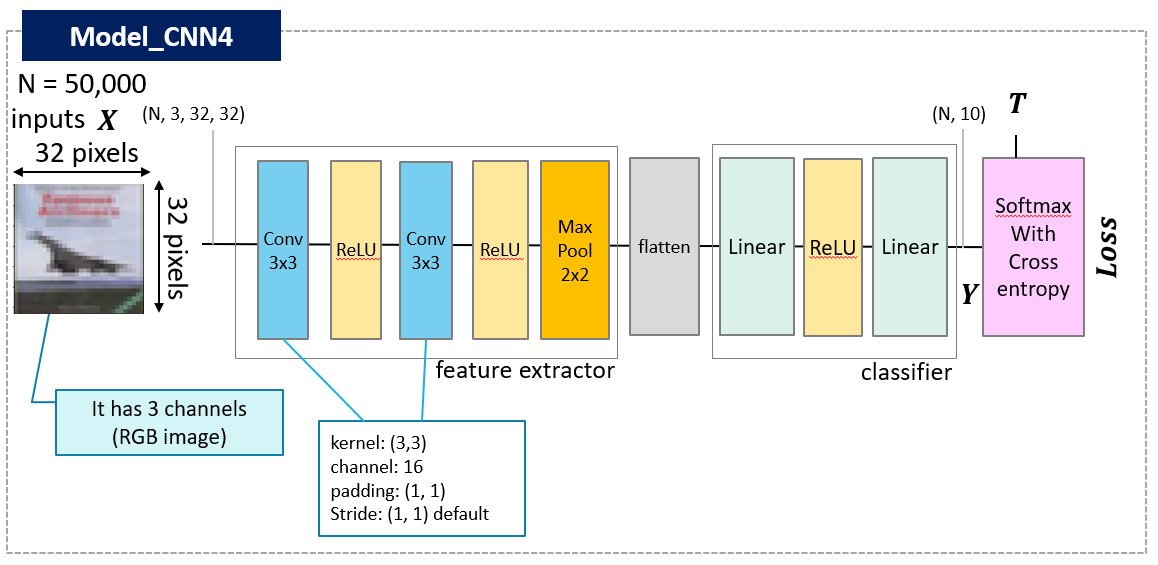

In [6]:
import torch.nn as nn
import torch.optim as optim

class Model_CNN4(nn.Module):
    def __init__(self):
        super().__init__()

        # input is (N, 3, 32, 32)
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(4096, 64)
        self.l2 = nn.Linear(64, 10)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool)
        
        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

model_cnn4 = Model_CNN4()
model_cnn4 = model_cnn4.to(device) # Send the model to GPU

# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# Optimizer
#optimizer_cnn4 = optim.SGD(model_cnn4.parameters(), lr=0.01)  # SGD, lr = learning rate
optimizer_cnn4 = optim.Adam(model_cnn4.parameters(), lr=0.001) # Adam, lr = learning rate

# for loss and accuracy recording
history_cnn4 = np.zeros((0,5))

summary(model_cnn4, (50000,3,32,32), depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
Model_CNN4                               [50000, 10]               --
├─Sequential: 1-1                        [50000, 16, 16, 16]       2,320
│    └─Conv2d: 2-1                       [50000, 16, 32, 32]       448
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-2                         [50000, 16, 32, 32]       --
├─Sequential: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [50000, 16, 32, 32]       2,320
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-4                         [50000, 16, 32, 32]       --
├─Sequential: 1-5                        --                        (recursive)
│    └─MaxPool2d: 2-5                    [50000, 16, 16, 16]       --
├─Flatten: 1-6                           [50000, 4096]             --
├─Sequential: 1-7                        [

## 🤔**Exercise 2.3** Learning with Model_CNN4

In [11]:
num_epochs = 10

history_cnn4 = fit(
    model = model_cnn4,
    optimizer = optimizer_cnn4,
    criterion = criterion,
    num_epochs = num_epochs,
    train_loader = train_loader_CIFAR10,
    test_loader = test_loader_CIFAR10,
    device = device,
    history = history_cnn4)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.01544 acc: 0.44330 val_loss: 0.01314, val_acc: 0.53230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.01213 acc: 0.57054 val_loss: 0.01162, val_acc: 0.58990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.01058 acc: 0.62896 val_loss: 0.01085, val_acc: 0.61960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.00957 acc: 0.66354 val_loss: 0.01045, val_acc: 0.63570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.00873 acc: 0.69342 val_loss: 0.00993, val_acc: 0.65810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.00807 acc: 0.71746 val_loss: 0.01012, val_acc: 0.65330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.00750 acc: 0.73632 val_loss: 0.01006, val_acc: 0.65590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.00702 acc: 0.75528 val_loss: 0.00988, val_acc: 0.66700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.00656 acc: 0.76882 val_loss: 0.01009, val_acc: 0.66600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.00613 acc: 0.78482 val_loss: 0.01038, val_acc: 0.66280


## **Example 2.1.1** Show loss and accuracy

Before learning: Loss: 0.01314 Accuracy: 0.53230
After learning : Loss: 0.01038 Accuracy: 0.66280


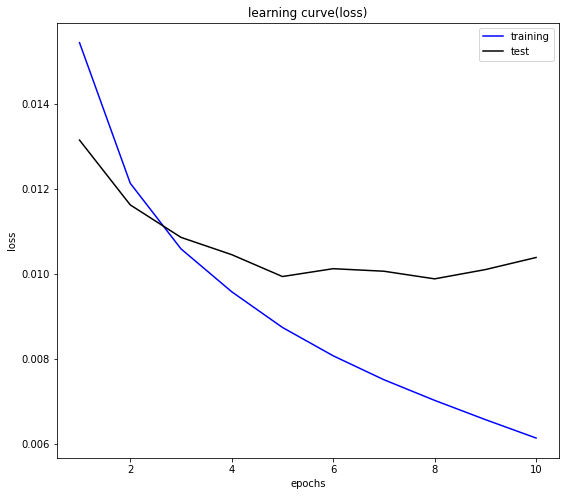

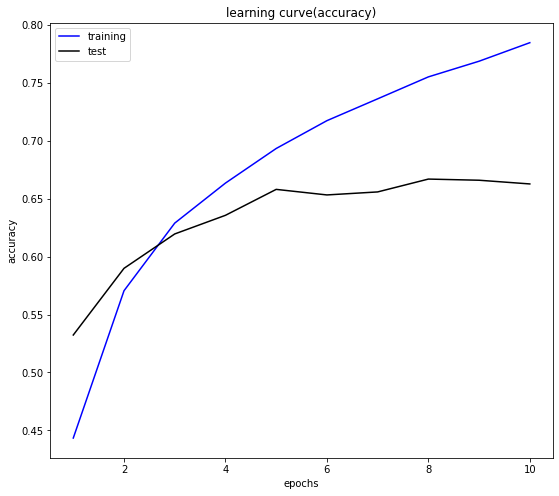

In [12]:
show_loss_and_accuracy_graph(history_cnn4)

## **Example 2.1.2** Show confusion matrix

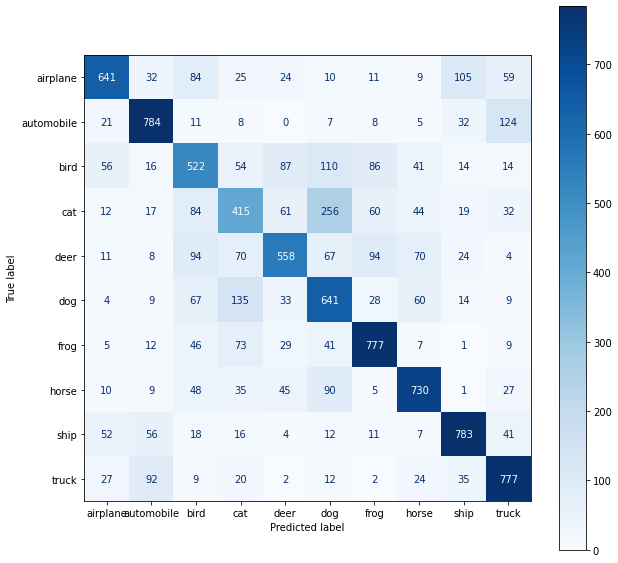

In [13]:
show_confusion_matrix(model=model_cnn4,
                      dataloader=test_loader_CIFAR10,
                      class_names=class_names_CIFAR10,
                      device=device)

## **Example 2.1.3** Visualizing the kernels of Model_CNN4

Model_CNN4(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=4096, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)


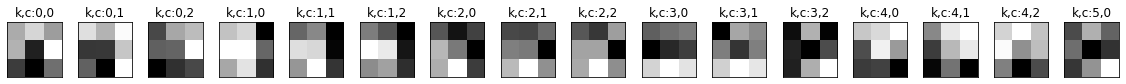

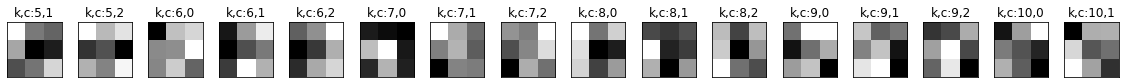

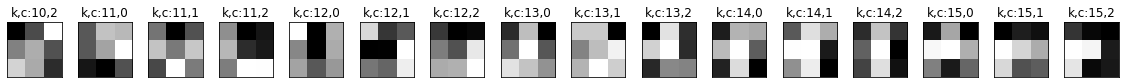

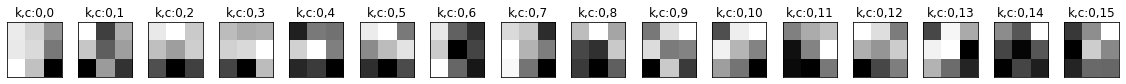

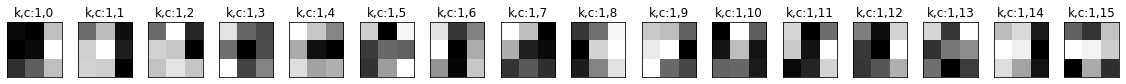

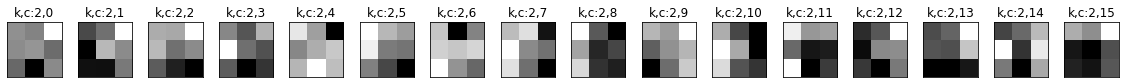

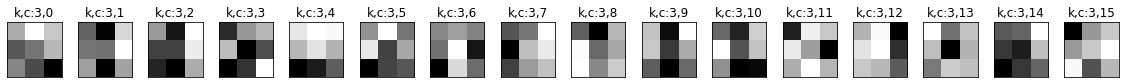

In [14]:
print(model_cnn4)
show_kernels(model=model_cnn4, kernel_key="conv1.weight", img_max_num=64)
show_kernels(model=model_cnn4, kernel_key="conv2.weight", img_max_num=64)

## **Example 2.1.4** Visualizing the feature maps of Model_CNN4

In [15]:
import torchvision.models.feature_extraction as feature_extraction

layer_names = feature_extraction.get_graph_node_names(model_cnn4)
print(layer_names)

(['x', 'conv1', 'relu', 'conv2', 'relu_1', 'maxpool', 'flatten', 'l1', 'relu_2', 'l2'], ['x', 'conv1', 'relu', 'conv2', 'relu_1', 'maxpool', 'flatten', 'l1', 'relu_2', 'l2'])


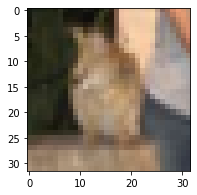

conv1 torch.Size([16, 32, 32])


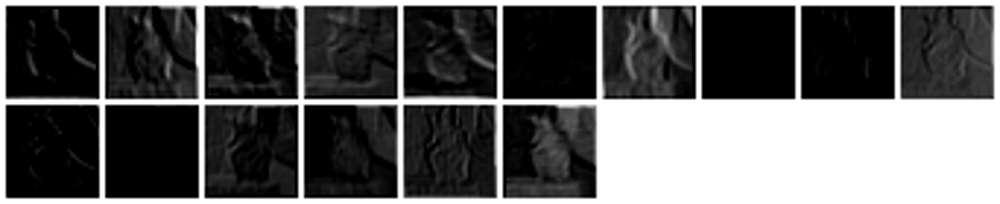

conv2 torch.Size([16, 32, 32])


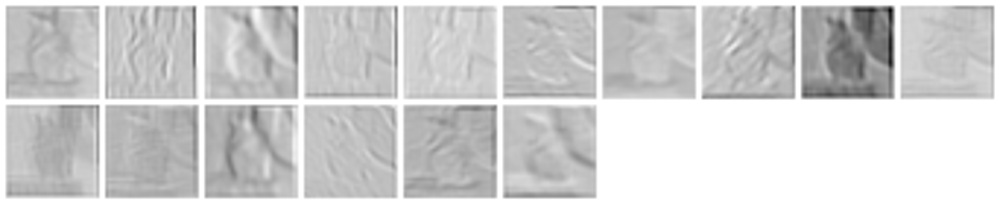

In [16]:
input, label = test_set_CIFAR10[46]
input = (input + 1) / 2
show_image(input.squeeze(0), imgtype="tensor", figsize=(3,3))

extractor = feature_extraction.create_feature_extractor(model_cnn4, ["conv1", "conv2"])
features = extractor(input.to(device))

show_features(features)

---
# Making checkpoint
---

### **Connect to Google Drive before doing this part**

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Example 2.2.1** Making directory in Google Drive

In [18]:
import os

data_dir = "./drive/MyDrive/IntroductionToDL/Model_CNN4"   # save all files to this dir in Google Drive
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

## **Example 2.2.2** Save the state_dict of model and optimizer separately

In [19]:
import os

model_filename = 'model_cnn4.pth'
optimizer_filename = 'optim_cnn4.pth'

model_path = os.path.join(data_dir, model_filename)   # ./drive/MyDrive/IntroductionToDL/Model_CNN4/model_cnn4.pth
optimizer_path = os.path.join(data_dir, optimizer_filename)   # ./drive/MyDrive/IntroductionToDL/Model_CNN4/optimizer_cnn4.pth

### Save state_dict of model
print("saving the model statet_dict to '{}'".format(model_path))
torch.save(model_cnn4.to('cpu').state_dict(), model_path)  # to('cpu') should be added when save

### Save state_dict of optimizer
print("saving the optimizer state_dict to '{}'".format(optimizer_path))
torch.save(optimizer_cnn4.state_dict(), optimizer_path)

saving the model statet_dict to './drive/MyDrive/IntroductionToDL/Model_CNN4/model_cnn4.pth'
saving the optimizer state_dict to './drive/MyDrive/IntroductionToDL/Model_CNN4/optim_cnn4.pth'


## **Example 2.2.3** Load the state_dict of model and optimizer separately

In [20]:
### Load state_dict of model

print("loading the model state_dict from '{}'".format(model_path))
model_cnn4.load_state_dict(torch.load(model_path))

print("loading the optimizer state_dict from '{}'".format(optimizer_path))
optimizer_cnn4.load_state_dict(torch.load(optimizer_path))

model_cnn4 = model_cnn4.to(device) # Trarnsfer the model to GPU

# Transfer the optimizer parts to GPU
# see https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/13
for state in optimizer_cnn4.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

loading the model state_dict from './drive/MyDrive/IntroductionToDL/Model_CNN4/model_cnn4.pth'
loading the optimizer state_dict from './drive/MyDrive/IntroductionToDL/Model_CNN4/optim_cnn4.pth'


## **Example 2.2.4** Save everything together as a checkpoint

In [21]:
import os

def save_checkpoint(model, optimizer, history, filepath):
    checkpoint = {
        'model_state_dict': model.to('cpu').state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
        }
    print("saving the checkpoint to '{}'".format(filepath))
    torch.save(checkpoint, filepath)


checkpoint_filename = 'checkpoint_cnn4.cpt'  # we use '.cpt' for checkpoint file. This extension is not common
checkpoint_path = os.path.join(data_dir, checkpoint_filename)   # ./drive/MyDrive/IntroductionToDL/Model_CNN4/checkpoint_cnn4.cpt
save_checkpoint(model_cnn4, optimizer_cnn4, history_cnn4, checkpoint_path)


saving the checkpoint to './drive/MyDrive/IntroductionToDL/Model_CNN4/checkpoint_cnn4.cpt'


## **Example 2.2.5** Load from the checkpoint

In [22]:
import os

# Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
def load_checkpoint(model, optimizer, filename):
    
    start_epoch = 0
    if os.path.isfile(filename):
        print("loading the checkpoint from '{}'".format(filename))
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        history = checkpoint['history']

    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, history

checkpoint_filename = 'checkpoint_cnn4.cpt'  # we use '.cpt' for checkpoint file. This extension is not common
checkpoint_path = os.path.join(data_dir, checkpoint_filename)   # ./drive/MyDrive/IntroductionToDL/Model_CNN4/checkpoint_cnn4.cpt
model_cnn4 , optimizer_cnn4, history_cnn4 = load_checkpoint(model_cnn4, optimizer_cnn4, checkpoint_path)
model_cnn4 = model_cnn4.to(device)

# Transfer the optimizer parts to GPU
# see https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/13
for state in optimizer_cnn4.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

loading the checkpoint from './drive/MyDrive/IntroductionToDL/Model_CNN4/checkpoint_cnn4.cpt'


---
# Classification of CIFER-10 using VGG-16
---

## **Example 2.3.1** Data Preparation of CIFER-10 for VGG-16 (Dataset, Transforms and DataLoader)

In [34]:
import torchvision.transforms as transforms     # Transforms
import torchvision.datasets as datasets         # for using dataset such as MNIST and CIFER-10
from torch.utils.data import DataLoader

### Transforms for preprocessing
transform_for_VGG16_train = transforms.Compose([
    transforms.Resize((64, 64)),             # resize from CIFER-10's shape 3x32x32 to 3x64x64
    transforms.RandomHorizontalFlip(p=0.5),  # for data augumentation
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False) # for data augumentation
])

transform_for_VGG16_test = transforms.Compose([
    transforms.Resize((64, 64)),      # resize from CIFER-10's shape 3x32x32 to 3x64x64
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])


### Datasetsfor training and testing (CIFAR-10 Dataset)
data_root = './data'
train_set_CIFAR10 = datasets.CIFAR10(
    root = data_root,
    train = True,
    download = True,
    transform = transform_for_VGG16_train
)

test_set_CIFAR10 = datasets.CIFAR10(
    root = data_root,
    train = False,
    download = True,
    transform = transform_for_VGG16_test
)

class_names_CIFAR10 = ('airplane',
                   'automobile',
                   'bird',
                   'cat',
                   'deer',
                   'dog',
                   'frog',
                   'horse',
                   'ship',
                   'truck')

### DataLoader

batch_size = 50
train_loader_CIFAR10 = DataLoader(
    train_set_CIFAR10,
    batch_size = batch_size,
    shuffle = True
)

test_loader_CIFAR10 = DataLoader(
    test_set_CIFAR10,
    batch_size = batch_size,
    shuffle = False
)



Files already downloaded and verified
Files already downloaded and verified


## **Example 2.3.2** Model definition (Model_VGG16)

In [35]:
import torch.nn as nn
import torch.optim as optim

class Model_VGG16(nn.Module):
    def __init__(self):
        super().__init__()

        layers = []
        #in_channels = 1  # initial channel num for Grayscale image
        in_channels = 3  # initial channel num for RGB image

        # config list to make vgg16 model. It has channel num of Conv layer and 'M' which means MaxPool layer
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]               # MaxPool layer
            else:
                layers += [nn.Conv2d(in_channels, v, kernel_size=3, padding=1)] # Conv3 layer 
                layers += [nn.ReLU(inplace=True)]                               # ReLU layer, inplace = If set to True, the variable will be overwritten directly to save memory.
                in_channels = v

        self.features = nn.Sequential(*layers)  # unpacking the list 'layers' using * operator 

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),         
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 10)        
        )
   
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

model_vgg16 = Model_VGG16()
model_vgg16 = model_vgg16.to(device) # Send the model to GPU

# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# SDG (stochastic gradient descent)
#optimizer = optim.SGD(model_vgg16.parameters(), lr=0.01, momentum=0.9)  # SGD, lr = learning rate
optimizer_vgg16 = optim.Adam(model_vgg16.parameters(), lr=0.0001) # Adam, lr = learning rate

# for loss and accuracy recording
history_vgg16 = np.zeros((0,5))

summary(model_vgg16, (10,3,64,64), depth=2)
#print(model_vgg16)

Layer (type:depth-idx)                   Output Shape              Param #
Model_VGG16                              [10, 10]                  --
├─Sequential: 1-1                        [10, 512, 2, 2]           --
│    └─Conv2d: 2-1                       [10, 64, 64, 64]          1,792
│    └─ReLU: 2-2                         [10, 64, 64, 64]          --
│    └─Conv2d: 2-3                       [10, 64, 64, 64]          36,928
│    └─ReLU: 2-4                         [10, 64, 64, 64]          --
│    └─MaxPool2d: 2-5                    [10, 64, 32, 32]          --
│    └─Conv2d: 2-6                       [10, 128, 32, 32]         73,856
│    └─ReLU: 2-7                         [10, 128, 32, 32]         --
│    └─Conv2d: 2-8                       [10, 128, 32, 32]         147,584
│    └─ReLU: 2-9                         [10, 128, 32, 32]         --
│    └─MaxPool2d: 2-10                   [10, 128, 16, 16]         --
│    └─Conv2d: 2-11                      [10, 256, 16, 16]         29

## **Example 2.3.3** Learning with (Model_VGG16)

This learning is time consuming (3 min per epoch maybe..)

In [36]:
num_epochs = 1    # The number of learning loop

history_vgg16 = fit(model = model_vgg16,
              optimizer = optimizer_vgg16,
              criterion = criterion,
              num_epochs = num_epochs,
              train_loader = train_loader_CIFAR10,
              test_loader = test_loader_CIFAR10,
              device = device,
              history = history_vgg16)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1], loss: 0.04606 acc: 0.10014 val_loss: 0.04605, val_acc: 0.10000


In [37]:
### save as checkpoint
import os

data_dir = "./drive/MyDrive/IntroductionToDL/Model_VGG16"   # save all files to this dir in Google Drive
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

checkpoint_filename = 'checkpoint_vgg16.cpt'  # we use '.cpt' for checkpoint file. This extension is not common
checkpoint_path = os.path.join(data_dir, checkpoint_filename)   # ./drive/MyDrive/IntroductionToDL/Model_CNN4/checkpoint_cnn4.cpt
save_checkpoint(model_vgg16, optimizer_vgg16, history_vgg16, checkpoint_path)

saving checkpoint './drive/MyDrive/IntroductionToDL/Model_VGG16/checkpoint_vgg16.cpt'


## **Example 2.3.4** Show loss and accuracy

Before learning: Loss: 0.04605 Accuracy: 0.10000
After learning : Loss: 0.04605 Accuracy: 0.10000


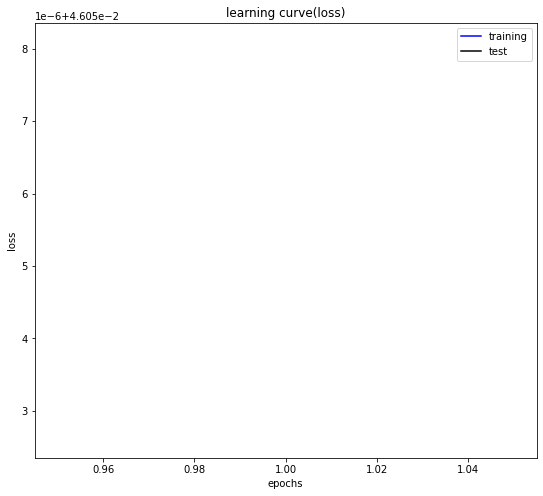

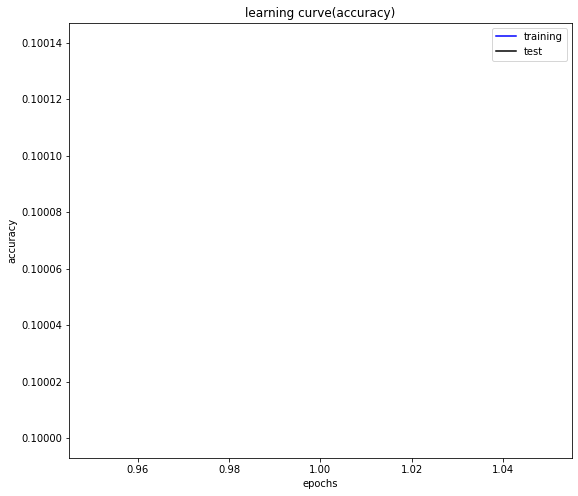

In [38]:
show_loss_and_accuracy_graph(history_vgg16)

## **Example 2.3.5** Show confusion matrix

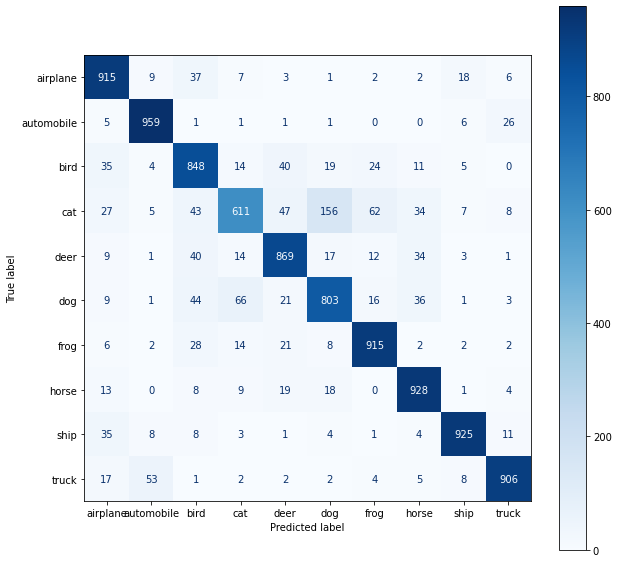

In [50]:
show_confusion_matrix(model=model_vgg16,
                      dataloader=test_loader_CIFAR10,
                      class_names=class_names_CIFAR10,
                      device=device)

## **Example 2.3.6** Show misrecognized images

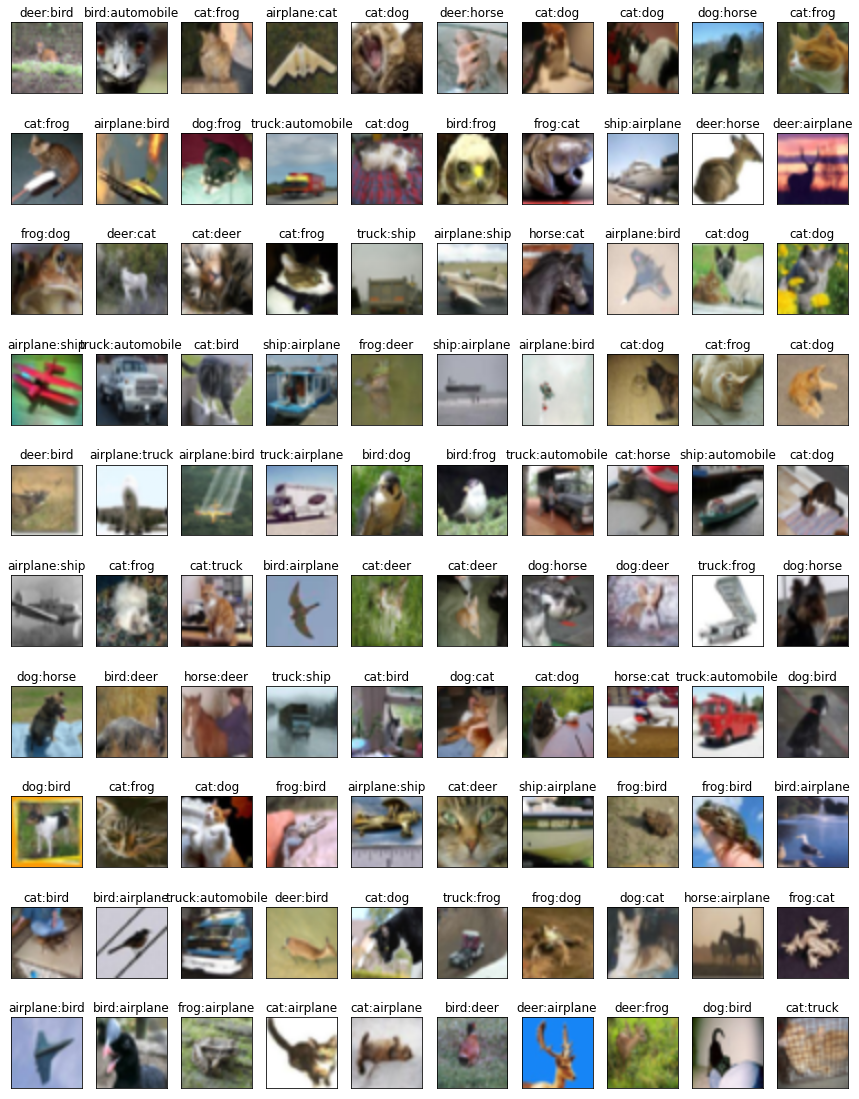

In [48]:
show_misrecognizd_images(model=model_vgg16,
                         dataloader=test_loader_CIFAR10,
                         img_shape=(3, 64, 64),
                         class_names=class_names_CIFAR10,
                         device=device)

## 🤔**Exercise 2.5** Using pre-trained parameters for VGG-11

In [45]:
import os

data_dir = "./drive/MyDrive/IntroductionToDL/Model_VGG11"   # Google Drive directory
checkpoint_filename = 'checkpoint_vgg16_30epoch.cpt'  # checkpoint filename

checkpoint_path = os.path.join(data_dir, checkpoint_filename)

model_vgg16 , optimizer_vgg16, history_vgg16 = load_checkpoint(model_vgg16, optimizer_vgg16, checkpoint_path)
model_vgg16 = model_vgg16.to(device)

# Transfer the optimizer parts to GPU
# see https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/13
for state in optimizer_vgg16.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

Streaming output truncated to the last 5000 lines.
          [1.8984e-05, 1.6467e-05, 1.3368e-05]],

         [[9.5954e-06, 1.4002e-05, 1.3815e-05],
          [6.7221e-06, 1.1941e-05, 1.4680e-05],
          [6.3858e-06, 9.6832e-06, 1.3886e-05]],

         ...,

         [[3.7551e-05, 2.8830e-05, 2.5915e-05],
          [5.6705e-05, 4.4365e-05, 3.3020e-05],
          [3.1505e-05, 3.5729e-05, 3.1153e-05]],

         [[3.4866e-05, 3.9406e-05, 4.2355e-05],
          [3.7181e-05, 4.0423e-05, 4.6144e-05],
          [4.2653e-05, 4.4914e-05, 4.8383e-05]],

         [[4.8299e-05, 4.9010e-05, 6.1404e-05],
          [6.9390e-05, 6.5780e-05, 6.8362e-05],
          [7.1778e-05, 6.1798e-05, 6.4855e-05]]],


        [[[5.6515e-06, 5.4736e-06, 4.6585e-06],
          [3.8686e-06, 3.8428e-06, 3.2419e-06],
          [2.3996e-06, 2.6374e-06, 2.2723e-06]],

         [[1.1891e-05, 1.6162e-05, 1.8039e-05],
          [3.6800e-06, 3.5959e-06, 3.7723e-06],
          [1.0057e-06, 8.6234e-07, 8.5417e-07]],

      

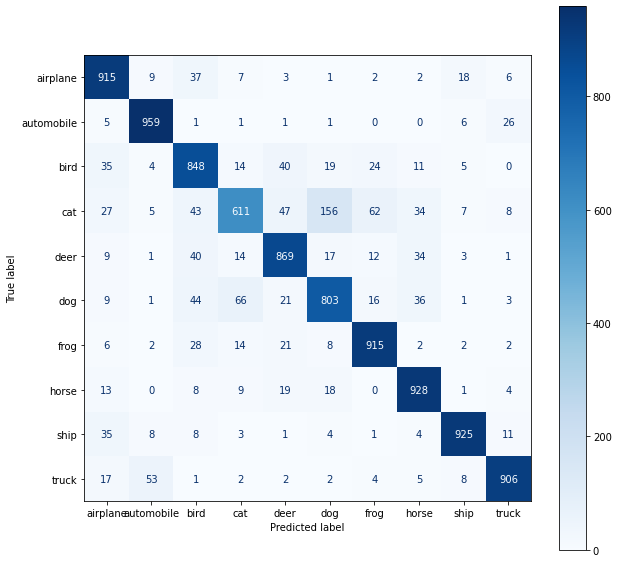

In [47]:
show_confusion_matrix(model=model_vgg16,
                      dataloader=test_loader_CIFAR10,
                      class_names=class_names_CIFAR10,
                      device=device)

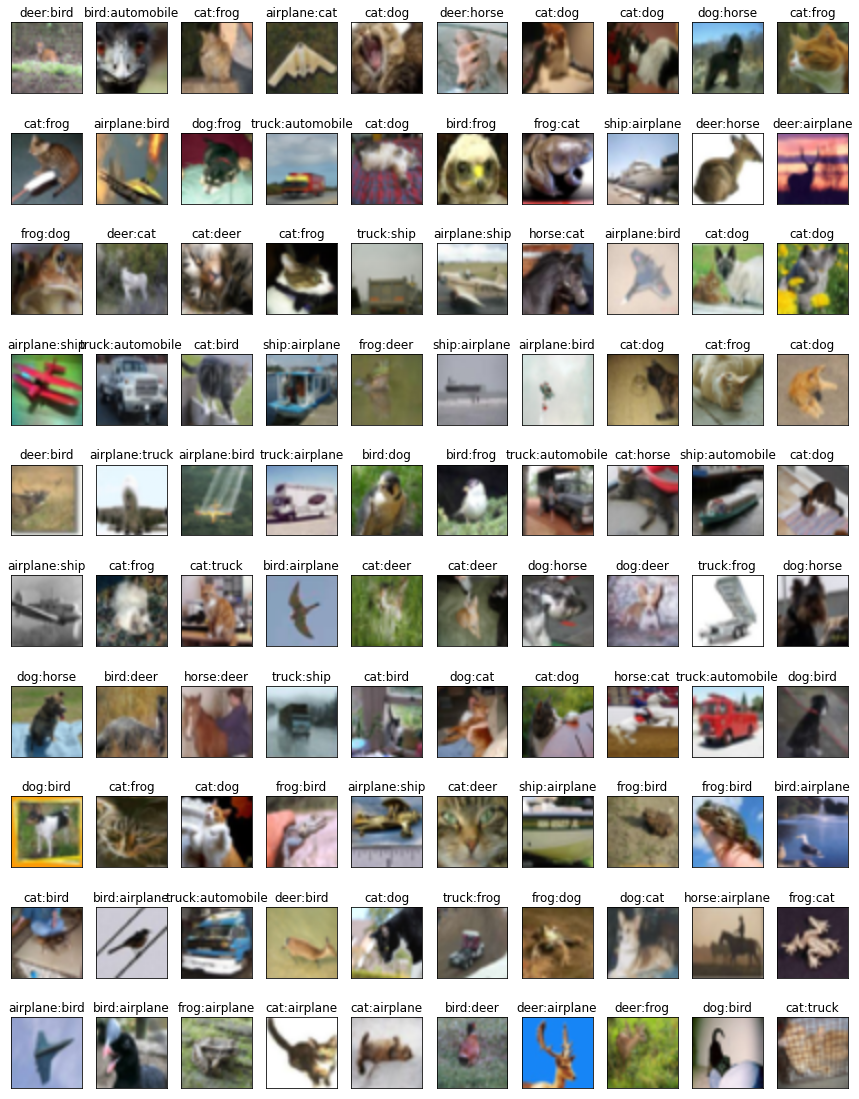

In [49]:
show_misrecognizd_images(model=model_vgg16,
                         dataloader=test_loader_CIFAR10,
                         img_shape=(3, 64, 64),
                         class_names=class_names_CIFAR10,
                         device=device)

## 🤔**Exercise 2.6** Let’s make VGG-11 model

In [53]:
import torch.nn as nn
import torch.optim as optim

class Model_VGG11(nn.Module):
    def __init__(self):
        super().__init__()

        ### Implement HERE ----------------------------------------------
        layers = []
        in_channels = 3

        cfg = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

        for v in cfg:
          if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
          else:
            layers += [nn.Conv2d(in_channels, v, kernel_size=3, padding=1)]
            layers += [nn.ReLU(inplace=True)]
            in_channels = v

        self.features = nn.Sequential(*layers)

        self.avgpool = nn.AdaptiveAvgPool2d((7,7))
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 10)
        )

        ### -------------------------------------------------------------



    def forward(self, x):

        ### Implement HERE ----------------------------------------------
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
        ### -------------------------------------------------------------

        
        
model_vgg11 = Model_VGG11()
model_vgg11 = model_vgg11.to(device) # Send the model to GPU

# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# SDG (stochastic gradient descent)
#optimizer = optim.SGD(model_vgg16.parameters(), lr=0.01, momentum=0.9)  # SGD, lr = learning rate
optimizer_vgg11 = optim.Adam(model_vgg11.parameters(), lr=0.0001) # Adam, lr = learning rate

# for loss and accuracy recording
history_vgg11 = np.zeros((0,5))

summary(model_vgg11, (10,3,64,64), depth=2)
#print(model_vgg11)

Layer (type:depth-idx)                   Output Shape              Param #
Model_VGG11                              [10, 10]                  --
├─Sequential: 1-1                        [10, 512, 2, 2]           --
│    └─Conv2d: 2-1                       [10, 64, 64, 64]          1,792
│    └─ReLU: 2-2                         [10, 64, 64, 64]          --
│    └─MaxPool2d: 2-3                    [10, 64, 32, 32]          --
│    └─Conv2d: 2-4                       [10, 128, 32, 32]         73,856
│    └─ReLU: 2-5                         [10, 128, 32, 32]         --
│    └─MaxPool2d: 2-6                    [10, 128, 16, 16]         --
│    └─Conv2d: 2-7                       [10, 256, 16, 16]         295,168
│    └─ReLU: 2-8                         [10, 256, 16, 16]         --
│    └─Conv2d: 2-9                       [10, 256, 16, 16]         590,080
│    └─ReLU: 2-10                        [10, 256, 16, 16]         --
│    └─MaxPool2d: 2-11                   [10, 256, 8, 8]           -

In [54]:
### Learn the VGG-11 model

num_epochs = 3    # The number of learning loop

history_vgg11 = fit(model = model_vgg11,
              optimizer = optimizer_vgg11,
              criterion = criterion,
              num_epochs = num_epochs,
              train_loader = train_loader_CIFAR10,
              test_loader = test_loader_CIFAR10,
              device = device,
              history = history_vgg11)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/3], loss: 0.03441 acc: 0.34482 val_loss: 0.02834, val_acc: 0.47030


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/3], loss: 0.02656 acc: 0.51030 val_loss: 0.02462, val_acc: 0.54690


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/3], loss: 0.02193 acc: 0.60358 val_loss: 0.01917, val_acc: 0.66040


## 🤔**Checking of the total params and validation accuracy**


* Model_VGG16
  * Total params: 134,301,514
  * val_acc: 0.10000
* Model_VGG11
  * Total params: 128,807,306  
  * val_acc: 0.66040